In [17]:
import argparse
import os
import sys
from pathlib import Path

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from torch.utils.data import DataLoader
from tqdm import tqdm

In [19]:
%matplotlib inline

In [20]:
%load_ext autoreload
%autoreload 2

torch.manual_seed(100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:

plt.style.use(["science", "ieee", "grid", "no-latex"])

In [22]:
try:
    IS_NOTEBOOK = True
    HERE = Path(__file__).resolve().parent
except NameError:
    IS_NOTEBOOK = False
    HERE = Path().resolve()

In [23]:
print(HERE)
sys.path.insert(0, str(Path(HERE, "../..").resolve()))  # kinship root

/home/warley/dev/kinship/notebooks/fg2025_2


In [24]:
print(sys.path)

['/home/warley/dev/kinship', '/home/warley/dev/kinship', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/home/warley/dev/kinship/.venv/lib/python3.11/site-packages', '/home/warley/dev/kinship/.venv/lib/python3.11/site-packages/setuptools/_vendor', '/tmp/tmptx3v5cvl']


In [25]:
from notebooks.dataset import FIW  # noqa: E402

from models.base import SimpleModel  # noqa: E402
from models.scl import SCL  # noqa: E402

In [26]:
def torch2numpy(img):
    """Convert a PyTorch tensor image to a NumPy array."""
    img = img.permute(1, 2, 0)
    img = img.clamp(0, 255)
    img = img.to(torch.uint8)
    return img.cpu().numpy()

In [27]:
def extract_embeddings(val_loader, model):
    embeddings = []
    labels = []
    items_id = []

    for item_id, img, family_id in tqdm(val_loader):
        with torch.no_grad():
            embedding, _ = model(img.cuda() / 255.0)
            embedding = embedding.cpu().numpy()
            embedding = normalize(embedding)
            embeddings.append(embedding)
            labels.append(family_id)
            items_id.append(item_id)

    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels)
    items_id = np.concatenate(items_id)

    return embeddings, labels, items_id

In [28]:
def plot_embeddings(embeddings, labels, items_id, dataset, plot_path):
    """Plot embeddings using t-SNE."""
    perplexities = [30]
    family_ids = [22, 53, 44, 63, 40]  # FaCoRNet
    colors = ["red", "blue", "green", "purple", "orange"]
    color_map = dict(zip(family_ids, colors))

    n_subplots = len(perplexities)
    n_col = 1
    n_row = int(np.ceil(n_subplots / n_col))

    fig, axes = plt.subplots(n_row, n_col, figsize=(7, 5 * n_row))
    axes = [axes] if n_row == 1 else axes.flatten()

    # Generate and plot embeddings
    plot_tsne(embeddings, labels, items_id, dataset, axes, perplexities, color_map)

    plt.tight_layout()
    if plot_path:
        Path(plot_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(plot_path)
    plt.show()

In [29]:
def plot_tsne(embeddings, labels, items_id, dataset, axes, perplexities, color_map):
    """Generate and plot t-SNE for different perplexity values."""
    for i, perplexity in enumerate(perplexities):
        print(f"Generating t-SNE with perplexity={perplexity}")
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=100)
        embeddings_2d = tsne.fit_transform(embeddings)

        # Get the limits from the embeddings
        x_min, x_max = np.min(embeddings_2d[:, 0]), np.max(embeddings_2d[:, 0])
        y_min, y_max = np.min(embeddings_2d[:, 1]), np.max(embeddings_2d[:, 1])

        # Calculate inset size relative to the axis limits
        width = (x_max - x_min) * 0.05
        height = (y_max - y_min) * 0.05

        ax = axes[i]  # Current subplot

        for label, color in color_map.items():
            idxs = [idx for idx, val in enumerate(labels) if val == str(label)]
            ax.scatter(
                embeddings_2d[idxs, 0],
                embeddings_2d[idxs, 1],
                color=color,
                label=f"Family {int(label):04}",
            )

            if idxs:  # Ensure there are indices for the family
                plot_emb_img(
                    ax, dataset, items_id, idxs, embeddings_2d, color_map, width, height
                )

        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.legend(loc="lower right")

In [30]:
def plot_emb_img(ax, dataset, items_id, idxs, embeddings_2d, color_map, width, height):
    """Plot three images in the insets of the given axis."""
    # Plot up to three images
    idxs = [idxs[0], idxs[len(idxs) // 2 + 1], idxs[-1]]
    for i, idx in enumerate(idxs):
        img = torch2numpy(dataset[items_id[idx]][1])

        family_id = dataset[idx][2]
        color_name = color_map.get(int(family_id), "black")

        # Convert color name to RGB tuple
        if color_name == "red":
            padding_color = (255, 0, 0)
        elif color_name == "blue":
            padding_color = (0, 0, 255)
        elif color_name == "green":
            padding_color = (0, 255, 0)
        elif color_name == "purple":
            padding_color = (128, 0, 128)
        elif color_name == "orange":
            padding_color = (255, 128, 0)
        else:
            padding_color = (0, 0, 0)

        # Pad the image
        pad_width = 5
        img = np.pad(
            img,
            pad_width=((pad_width, pad_width), (pad_width, pad_width), (0, 0)),
            mode="constant",
            constant_values=0,
        )

        # Fill the padded area with the desired color
        img[:pad_width, :, :] = padding_color  # Top
        img[-pad_width:, :, :] = padding_color  # Bottom
        img[:, :pad_width, :] = padding_color  # Left
        img[:, -pad_width:, :] = padding_color  # Right

        # Calculate position for each image inset
        img_x = embeddings_2d[idx, 0] - width / 2 + (i * (width + 0.01))
        img_y = embeddings_2d[idx, 1] - height / 2

        imgbox = ax.inset_axes((img_x, img_y, width, height), transform=ax.transData)
        imgbox.imshow(img)
        imgbox.axis("off")

In [31]:
def setup(root_dir, ckpt_path, batch_size, samples_per_member, gpu: int = 0):
    # Loading and sampling the dataset
    val_dataset = FIW(
        root_dir=root_dir,
        families=[22, 53, 44, 63, 40],
        samples_per_member=samples_per_member,
    )
    val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=False)

    # Loading model
    checkpoint = torch.load(ckpt_path)
    simple_model = SimpleModel("adaface_ir_101", projection=None)
    model = SCL(model=simple_model, loss=None)
    model.load_state_dict(checkpoint["state_dict"])
    model.eval()
    model.cuda()

    model = model.model.backbone

    return model, val_loader

In [32]:
def run(model, val_loader, plot_path: str = ""):
    # Extracting embeddings
    embeddings, labels, items_id = extract_embeddings(val_loader, model)

    # Plotting
    plot_embeddings(embeddings, labels, items_id, val_loader.dataset, plot_path)

In [33]:
def parser():
    parser = argparse.ArgumentParser(description="plot embeddings")
    parser.add_argument("--root_dir", type=str, help="root directory of dataset")
    parser.add_argument("--ckpt_path", type=str, help="model save path")
    parser.add_argument("--plot_path", type=str, help="plot save path")
    parser.add_argument(
        "--batch_size", type=int, default=40, help="batch size default 40"
    )
    parser.add_argument("--gpu", default="0", type=str, help="gpu id you use")
    args = parser.parse_args()
    os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu
    return args

100%|██████████| 5/5 [00:00<00:00, 3252.41it/s]
/tmp/ipykernel_494062/3365882143.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)


Total samples: 114


100%|██████████| 3/3 [00:00<00:00,  7.03it/s]


Generating t-SNE with perplexity=30


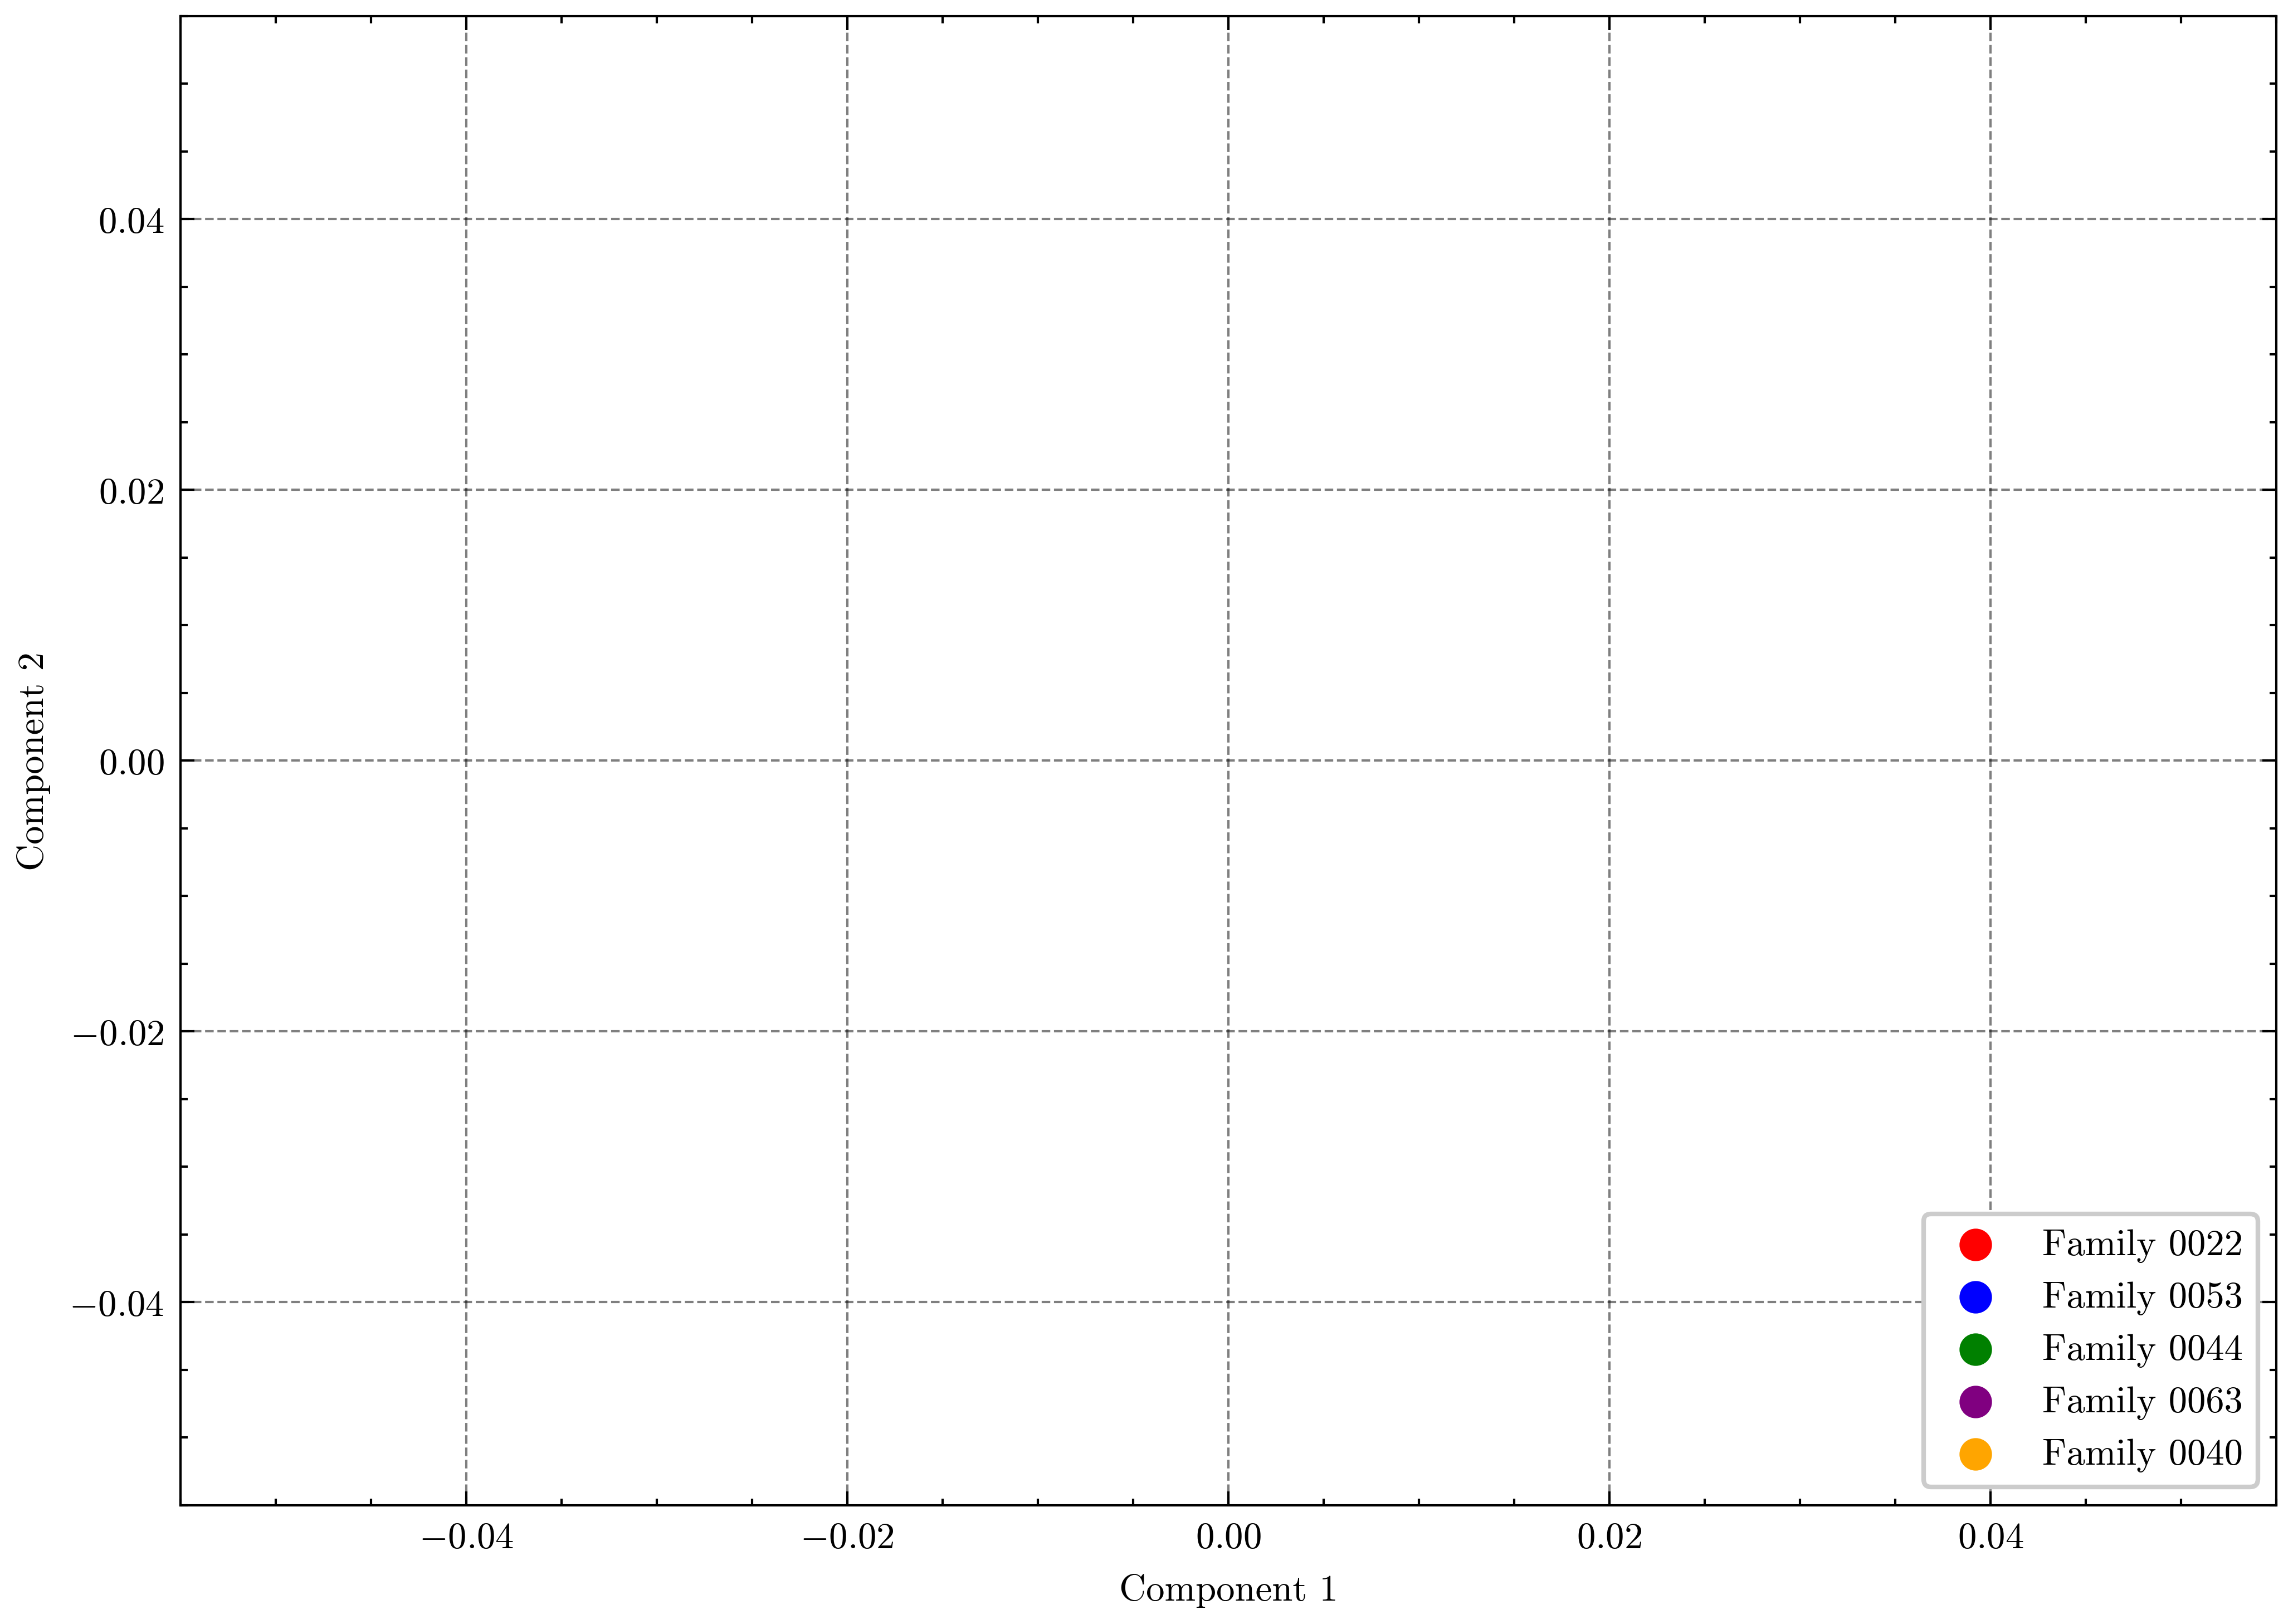

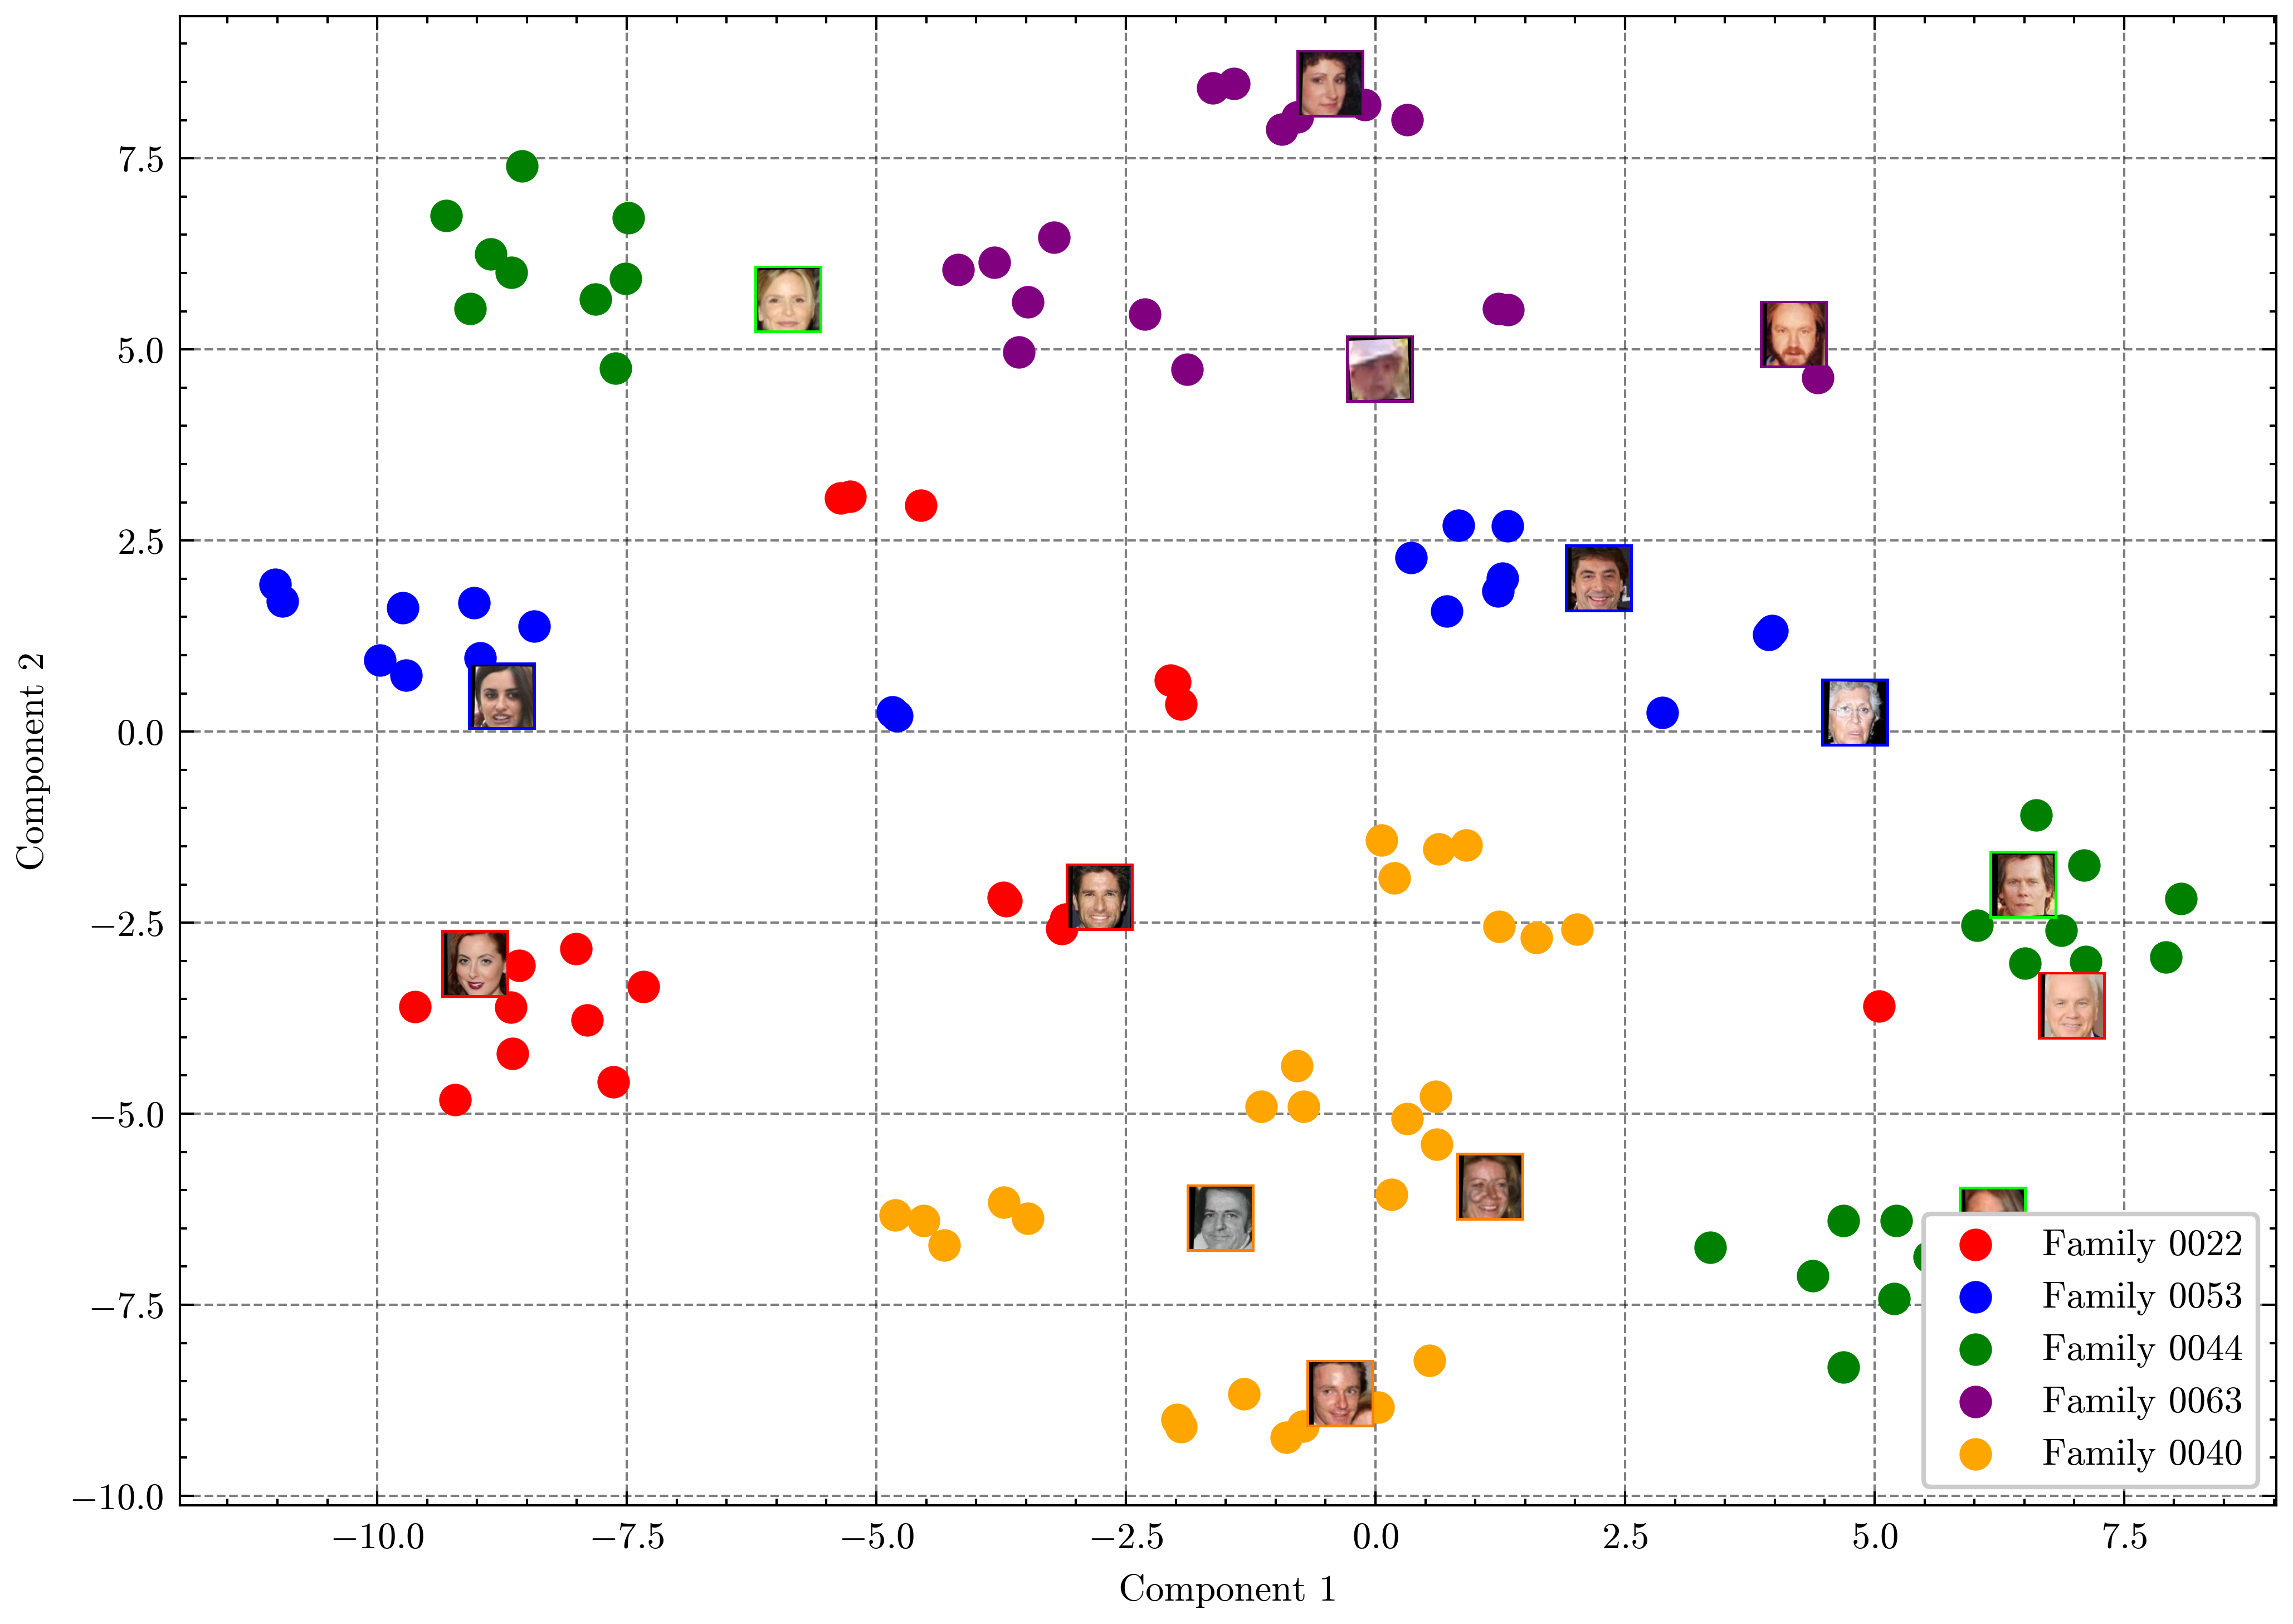

In [34]:
if IS_NOTEBOOK and False:
    if __name__ == "__main__":
        args = parser()
        run(**vars(args))
else:
    root_dir = Path(HERE, "../../data/fiw/track1/images/Validation_A/val-faces")
    batch_size = 40
    experiment = "8dbc5e6774184cf5be484af7861d5512"
    checkpoint = "44-4.301-2.848-0.878422.ckpt"
    ckpt_path = Path(
        Path.home(), f".guild/runs/{experiment}/exp/checkpoints/{checkpoint}"
    )
    plot_path = "plots_experiments/tsne.png"
    model, val_loader = setup(root_dir, ckpt_path, batch_size, samples_per_member=100)
    run(model, val_loader, plot_path)